In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import osmnx as ox
import geopandas as gpd
import itertools
import time
import random
import ast

In [2]:
# Utils & Functions
from utils import *
from hrga import *
from tndp import *
from export import *
from plot import *

### Graph Structure for Instance 1 (Toy Instance)

Example taken from Guan et al. (2006). 9-node network used to test basic functioning of model and restrictions. There is only one possible path from any origin to any destination.

In [3]:
# Generating Mandl's Network

# Create graph
G = nx.Graph()

# Node Positions
node_positions = [(-2, 1), (-2, -1), (-1, 0), (0, 1), (0, 0), (0, -1), (1, 0), (2, 1), (2, -1)]

# Add nodes
for i in range(9):
    G.add_node(i+1, pos=node_positions[i])
    

    
# Add edges
edge_list =    [(1, 3), (2, 3), (3, 5), (5, 4), (5, 6), (5, 7), (7, 8), (7, 9)]
edge_lengths = [    10,     10,     10,     10,     10,     10,     10,     10]

for i in range(len(edge_list)):
    G.add_edge(*edge_list[i], length=edge_lengths[i])

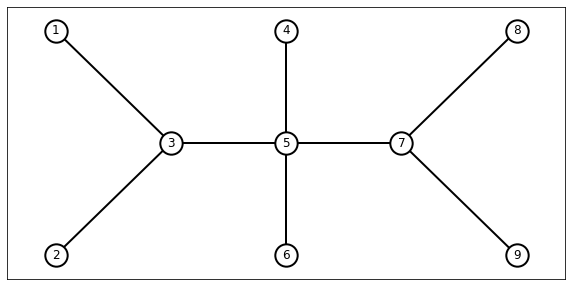

In [4]:
# Plot Graph
f, ax = plt.subplots(figsize=(10, 5))

pos = nx.get_node_attributes(G, 'pos')

node_plot = nx.draw_networkx_nodes(G, pos, node_color='white', node_size=500)
edges_plot = nx.draw_networkx_edges(G, pos, width=2)
labels_plot = nx.draw_networkx_labels(G, pos)

# Change border
node_plot.set_edgecolor('k')
node_plot.set_linewidth(2)

# Display
plt.show()

#### Generating All Possible Routes

Generate all possible routes by enumerating shortest paths from any origin $i$ to any destination $j$. In a more realistic set, we would consider the $k$ shortest paths. This graph, however, has only 1 possible path from any origin to any destination.

In [5]:
# Initialize List
routes = []

# Iterate
for origin in list(G.nodes()):
    for destination in list(G.nodes()):
        
        # If origin is not destination...
        if origin != destination:
             routes.append(nx.shortest_path(G, origin, destination, weight='length'))

In [6]:
# Apply function
unique = unique_routes(routes)
print(f'Number of feasible routes (after removing simetrical routes): {len(unique)}')

Number of feasible routes (after removing simetrical routes): 36


#### Generate Demand Matrix

Generate a demand matrix for all OD pairs.

In [9]:
# Initialize matrix with full demand
demand_matrix = np.full((len(G.nodes()), len(G.nodes())), 5)

# Remove diagonal
np.fill_diagonal(demand_matrix, 0)

# Print
print(demand_matrix)

[[0 5 5 5 5 5 5 5 5]
 [5 0 5 5 5 5 5 5 5]
 [5 5 0 5 5 5 5 5 5]
 [5 5 5 0 5 5 5 5 5]
 [5 5 5 5 0 5 5 5 5]
 [5 5 5 5 5 0 5 5 5]
 [5 5 5 5 5 5 0 5 5]
 [5 5 5 5 5 5 5 0 5]
 [5 5 5 5 5 5 5 5 0]]


#### Generate $\Delta$ Matrix

Generate $\Delta_{er}$ matrix. This matrix tells if edge $e \in E$ is part of route $r \in R$.

In [10]:
DELTA = generate_DELTA_matrix(G, routes)
print(f'DELTA Matrix: \n')
print(DELTA)

DELTA Matrix: 

[[1 1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0]
 [1 0 1 1 0 0 0 0]
 [1 0 1 0 0 0 0 0]
 [1 0 1 0 1 0 0 0]
 [1 0 1 0 0 1 0 0]
 [1 0 1 0 0 1 1 0]
 [1 0 1 0 0 1 0 1]
 [0 1 0 0 0 0 0 0]
 [0 1 1 1 0 0 0 0]
 [0 1 1 0 0 0 0 0]
 [0 1 1 0 1 0 0 0]
 [0 1 1 0 0 1 0 0]
 [0 1 1 0 0 1 1 0]
 [0 1 1 0 0 1 0 1]
 [0 0 1 1 0 0 0 0]
 [0 0 1 0 0 0 0 0]
 [0 0 1 0 1 0 0 0]
 [0 0 1 0 0 1 0 0]
 [0 0 1 0 0 1 1 0]
 [0 0 1 0 0 1 0 1]
 [0 0 0 1 0 0 0 0]
 [0 0 0 1 1 0 0 0]
 [0 0 0 1 0 1 0 0]
 [0 0 0 1 0 1 1 0]
 [0 0 0 1 0 1 0 1]
 [0 0 0 0 1 0 0 0]
 [0 0 0 0 0 1 0 0]
 [0 0 0 0 0 1 1 0]
 [0 0 0 0 0 1 0 1]
 [0 0 0 0 1 1 0 0]
 [0 0 0 0 1 1 1 0]
 [0 0 0 0 1 1 0 1]
 [0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 1]]


#### Enumerate Paths

Since we are working with a small instance and all origin-destination pairs have only one possible path, we are going to enumerate all possible paths from all origins and all destinations. If we were working with an instance that allowed for multiple paths, we would calculate the $k$ shortest paths from any origin to any destination.

Since there is only one path from any origin to any destination, the set of possible paths is identical to the set of routes.

In [11]:
# Generate OD Pairs List
od_pairs = generate_od_pair_list(G, demand_matrix)

In [12]:
# Generate Paths
paths, num_paths = generate_paths(G, od_pairs)

#### Generate $\delta$ Tensor

The $\delta_{ep}^{od}$ tensor indicates if the edge $e$ is used on path $p$ chosen from origin $o$ to destination $d$. It allows for the coupling of routes and paths in the optimization model.

This matrix has shape $[od][k][e]$

In [13]:
# Generate Matrix
delta = generate_delta_matrix(G, od_pairs, num_paths, paths)
#delta

#### Generate Outputs

In [14]:
# Nodes
node_ids = list(G.nodes())
node_x = [G.nodes[node]['pos'][0] for node in G.nodes()]
node_y = [G.nodes[node]['pos'][1] for node in G.nodes()]


# Data
node_data = {
    'id' : node_ids,
    'x' : node_x,
    'y' : node_y,
}

# Dataframe
nodes_df = pd.DataFrame(data=node_data)

# Print
#nodes_df

In [15]:
# Edges
edge_ids = [id + 1  for id in range(len(G.edges()))]
edge_origins = [u for u, v in G.edges()]
edge_destinations = [v for u, v in G.edges()]
edge_lengths = [G[u][v]['length'] for u, v in G.edges()]
edge_travel_time = [G[u][v]['length'] for u, v in G.edges()]
edge_capacity = [10 for edge in range(len(G.edges()))]

# Data
edge_data = {
    'id' : edge_ids,
    'origin' : edge_origins,
    'destination' : edge_destinations,
    'length' : edge_lengths,
    'travel_time' : edge_travel_time,
    'capacity' : edge_capacity
}

# Dataframe
edges_df = pd.DataFrame(data=edge_data)

# Print
#edges_df

In [16]:
# OD Matrix
od_ids = [id + 1 for id in range(len(od_pairs))]
od_origin = [int(od.split('-')[0]) for od in od_pairs]
od_destination = [int(od.split('-')[1]) for od in od_pairs]
od_demand = [demand_matrix[int(od.split('-')[0]) - 1][int(od.split('-')[1]) - 1] for od in od_pairs]
od_paths = [num_paths[od] for od in od_pairs]

# Data
od_data = {
    'id' : od_ids,
    'origin' : od_origin,
    'destination' : od_destination,
    'demand' : od_demand,
    'paths' : od_paths
}

# Dataframe
od_df = pd.DataFrame(data=od_data)
#od_df

In [17]:
# Routes
route_ids = [id + 1 for id in range(len(routes))]
route_sequences = [str(sequence) for sequence in routes]
route_length = [nx.path_weight(G, route, weight='length') for route in routes]
route_stops = [len(route) for route in routes]

# Data
route_data = {
    'id' : route_ids,
    'sequence' : route_sequences,
    'length' : route_length,
    'num_stops' : route_stops
}

route_df = pd.DataFrame(data=route_data)
#route_df

In [18]:
k = 10

# Paths
paths_id = [id + 1 for id in range(len(paths) * k)]
paths_sequence = [str(paths[od][i]) if i < len(paths[od]) else '' for od in paths for i in range(k)]
paths_length = [nx.path_weight(G, paths[od][i], weight='length') if i < len(paths[od]) else 0 for od in paths for i in range(k)]
paths_stops = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in paths for i in range(k)]

# Data
paths_data = {
    'id' : paths_id,
    'sequence' : paths_sequence,
    'length' : paths_length,
    'num_stops' : paths_stops
}

paths_df = pd.DataFrame(data=paths_data)
#paths_df

In [19]:
# DELTA Matrix
DELTA_value = [edge for route in DELTA for edge in route]
edge_ids = [id + 1 for id in range(len(G.edges()))] * len(routes)
route_ids = [id + 1 for id in range(len(routes)) for i in range(len(G.edges()))]

# Data
DELTA_data = {
    'route_id' : route_ids,
    'edge_id' : edge_ids,    
    'DELTA' : DELTA_value
}

# Dataframe
DELTA_df = pd.DataFrame(data=DELTA_data)
#DELTA_df

In [20]:
k = 10

# delta Matrix
delta_value = [edge for od in delta for path in od for edge in path]
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]
path_ids = [id + 1 for id in range(k) for edge in range(len(G.edges()))] * len(od_pairs)
edge_ids = [id + 1 for id in range(len(G.edges()))] * k * len(od_pairs)

od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k) for j in range(len(G.edges()))]

# Data
delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'edge' : edge_ids,
    'delta' : delta_value,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
delta_df = pd.DataFrame(data=delta_data)
#delta_df

In [21]:
# CSVs
# nodes_df.to_csv('exports/instance_01/nodes.csv', index=False, sep=',')
# edges_df.to_csv('exports/instance_01/edges.csv', index=False, sep=',')
# od_df.to_csv('exports/instance_01/od_matrix.csv', index=False, sep=',')
# DELTA_df.to_csv('exports/instance_01/big_delta.csv', index=False, sep=',')
# delta_df.to_csv('exports/instance_01/small_delta.csv', index=False, sep=',')
# route_df.to_csv('exports/instance_01/routes.csv', index=False, sep=',')
# paths_df.to_csv('exports/instance_01/paths.csv', index=False, sep=',')

#### Preprocess Y Variable

In [22]:
# Vectors
y_fix_od = []
y_fix_r  = []

# Iterate over OD pairs
for i, row in od_df.iterrows():
    
    # Iterate over routes
    for i, route in enumerate(routes):
        
        # If neither origin, nor destination in route, add do vector
        if (row['origin'] not in route) and (row['destination'] not in route):
            
            y_fix_od.append(row['id'])
            y_fix_r.append(i+1)
            
# Print Results
print(f'y_od_r original size: {od_df.shape[0] * len(routes)}')
print(f'fixed_variables: {len(y_fix_od)}')
print(f'y_od_r simplified size: {(od_df.shape[0] * len(routes)) - len(y_fix_od)}')

y_od_r original size: 2592
fixed_variables: 984
y_od_r simplified size: 1608


#### Reduce Dimensionality of $\delta$ Matrix

In [23]:
# Initialize W Vector
od_path_edge = []
start_index  = []
finish_index = []

# Counter
i = 0

# Rename edges_df
df = edges_df

# Iterate over OD pairs
for j, od in enumerate(od_pairs):
    
    i += 1
    
    if j % 100 == 0:
        print(f'iterating over od pair {j+1}/{len(od_pairs)}' )
    
    # Iterate over paths
    for k in range(10):# enumerate(paths[od]):

        # If index in range
        if k < len(paths[od]):
           
            # Convert path to edges
            edges_path = path_nodes_to_edges(paths[od][k])

            # Add Starting Index
            start_index.append(i)

            # I
            i += len(edges_path) - 1

            # Add Ending Index
            finish_index.append(i)
            
            # I
            #i += 1 

            # Iterate over edges
            for edge in edges_path:

                # Find edge id
                edge_id = df[((df.origin == edge[0]) & (df.destination == edge[1])) | ((df.origin == edge[1]) & (df.destination == edge[0]))].id.values[0]

                # Add id to list
                od_path_edge.append(edge_id)            
        
        # If out of range...
        else:
            
            # Add Starting Index
            start_index.append(i)

            # Add Ending Index
            finish_index.append(i)

iterating over od pair 1/72


In [24]:
print(f'Length of vector: {len(od_path_edge)}')

Length of vector: 168


In [25]:
k = 10

# delta Matrix
od_ids = [id + 1 for id in range(len(od_pairs)) for i in range(k)]
path_ids = [id + 1 for id in range(k)] * len(od_pairs)
path_size = [len(paths[od][i]) if i < len(paths[od]) else 0 for od in od_pairs for i in range(k)]
od_origins = [int(od_pairs[id].split('-')[0]) for id in range(len(od_pairs)) for i in range(k)]
od_destinations = [int(od_pairs[id].split('-')[1]) for id in range(len(od_pairs)) for i in range(k)]


# Data
reduced_delta_data = {
    'od' : od_ids,
    'path' : path_ids,
    'path_size' : path_size,
    'w_start' : start_index,
    'w_finish' : finish_index,
    'origin' : od_origins,
    'destination' : od_destinations
}

# DataFrame
reduced_delta_df = pd.DataFrame(data=reduced_delta_data)
reduced_delta_df

,od,path,path_size,w_start,w_finish,origin,destination
0,1,1,3,1,2,1,2
1,1,2,0,2,2,1,2
2,1,3,0,2,2,1,2
3,1,4,0,2,2,1,2
4,1,5,0,2,2,1,2
...,...,...,...,...,...,...,...
715,72,6,0,168,168,9,8
716,72,7,0,168,168,9,8
717,72,8,0,168,168,9,8
718,72,9,0,168,168,9,8


In [26]:
orig = delta_df.shape[0]
redu = len(od_path_edge)

print(f'Expected Reduction in Dimensionality: from {orig} elements to {redu} elements. A {((1 - (redu/orig)) * 100):.2f} % reduction')

Expected Reduction in Dimensionality: from 5760 elements to 168 elements. A 97.08 % reduction


#### Reduce Dimensionality of $\Delta$ Matrix

In [27]:
# Initialize Vectors
route_list = []

edge_list = []
start_pos = []
end_pos = []

# Initialize Counter
e_start = 0

# Iterate over edges
for i, edge in enumerate(list(G.edges())):
    
    # Add 1
    #e_start += 1
    
    # Append Data
    edge_list.append(i+1)
    start_pos.append(e_start+1)
    
    # Iterate over routes
    for route in routes:
    
        # Transform route from nodes to edges
        route_edges = path_nodes_to_edges(route)

        # If edge in route
        if (edge in route_edges) or (edge[::-1] in route_edges):
            
            # Add 1 to counter
            e_start += 1
            
            # Find route ID
            route_id = route_df[route_df.sequence == str(route)].id.values[0]

            # Append Data
            route_list.append(route_id)
            
            
    
    # Append Finish
    end_pos.append(e_start)

In [28]:
len(route_list)

84

### Manual Array Initialization

In [29]:
sizes = [len(G.nodes()), len(G.edges()), len(od_pairs), len(routes), k, len(od_path_edge), len(route_list), len(y_fix_od)] 

print(f'OD Pairs  = {len(od_pairs)}')
print(f'Routes    = {len(routes)}')
print(f'Nodes     = {len(G.nodes())}')
print(f'Edges     = {len(G.edges())}')
print(f'Max_Paths = {k}')

OD Pairs  = 72
Routes    = 36
Nodes     = 9
Edges     = 8
Max_Paths = 10


In [ ]:
# return_xpress_int_txt(sizes, filename='exports/instance_01/array_sizes.txt')

**Node Data**

In [ ]:
# return_xpress_int_txt(nodes_df.id, filename='exports/instance_01/node_id.txt')
# return_xpress_str_txt(nodes_df.id, filename='exports/instance_01/node_name.txt')

**Edge Data**

In [ ]:
uv = list(edges_df.origin.values) + list(edges_df.destination.values)

In [ ]:
# return_xpress_int_txt(edges_df.id, filename='exports/instance_01/edge_id.txt')
# return_xpress_int_txt(uv, filename='exports/instance_01/edge_uv.txt')
# return_xpress_int_txt(edges_df.length, filename='exports/instance_01/edge_length.txt')
# return_xpress_int_txt(edges_df.travel_time, filename='exports/instance_01/edge_time.txt')
# return_xpress_int_txt(edges_df.capacity, filename='exports/instance_01/edge_capacity.txt')

**OD Matrix Data**

In [ ]:
# return_xpress_int_txt(od_df.origin, filename='exports/instance_01/origins.txt')
# return_xpress_int_txt(od_df.destination, filename='exports/instance_01/destinations.txt')
# return_xpress_int_txt(od_df.demand, filename='exports/instance_01/demand.txt')

**Routes**

In [ ]:
frequencies = [1 for route in routes]

In [ ]:
# return_xpress_str_txt(route_df.sequence.values, filename='exports/instance_01/route_sequence.txt')
# return_xpress_int_txt(route_df.length.values, filename='exports/instance_01/route_length.txt')
# return_xpress_int_txt(frequencies, filename='exports/instance_01/route_frequency.txt')

**Paths**

In [ ]:
# return_xpress_str_txt(paths_df.sequence.values, filename='exports/instance_01/path_sequence.txt')
# return_xpress_int_txt(paths_df.length, filename='exports/instance_01/path_length.txt')

**Y Preprocessing**

In [ ]:
# return_xpress_int_txt(y_fix_od, filename='exports/instance_01/yfix_origin_destination.txt')
# return_xpress_int_txt(y_fix_r, filename='exports/instance_01/yfix_routes.txt')

**$\delta$ Dimensionality Redux**

In [ ]:
# return_xpress_int_txt(od_path_edge, filename='exports/instance_01/small_delta.txt')
# return_xpress_int_txt(reduced_delta_df.w_start, filename='exports/instance_01/small_delta_start.txt')
# return_xpress_int_txt(reduced_delta_df.w_finish, filename='exports/instance_01/small_delta_finish.txt')

**$\Delta $ Dimensionality Redux**

In [69]:
# return_xpress_int_txt(route_list, filename='exports/instance_01/big_delta.txt')
# return_xpress_int_txt(start_pos, filename='exports/instance_01/big_delta_start.txt')
# return_xpress_int_txt(end_pos, filename='exports/instance_01/big_delta_finish.txt')

DONE | File exports/instance_01/big_delta.txt saved to disk.
